In [1]:
# statistics on synapses based on radii of terminal branches
# Get synapse density for cells as a function of radius of branches (syn density/radius - plot as function of dist from soma?)
# get avg cell type statistics? 
# for each cell type, get the trend of distance from soma and branch area

In [2]:
import caveclient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/Users/anamika.agrawal/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# links to connectomics data
# google bucket: gs://allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups
# amazon aws: s3://em-connectomics-data/

In [4]:
client  = caveclient.CAVEclient('minnie65_public_v343')


In [5]:
client.materialize.get_tables()

['synapses_pni_2',
 'nucleus_neuron_svm',
 'nucleus_detection_v0',
 'functional_coreg',
 'allen_v1_column_types_slanted',
 'aibs_column_nonneuronal',
 'func_unit_em_match_release',
 'proofreading_status_public_release',
 'aibs_soma_nuc_metamodel_preds_v117']

In [6]:
import pandas as pd
import cloudfiles
import os
import io
import re
import sys
from meshparty import meshwork

def fix_local_cloudpath(cloudpath):
    if "://" not in cloudpath:
        dir, _ = os.path.split(cloudpath)
        if len(dir) == 0:
            cloudpath = './' + cloudpath
        cloudpath = "file://" + cloudpath
    return cloudpath

def get_path_files(cloudpath, regex_template=None):
    cloudpath = fix_local_cloudpath(cloudpath)
    cf = cloudfiles.CloudFiles(cloudpath,use_https=True)
    if regex_template is None:
        filenames = [f"{cloudpath}/{fn}" for fn in cf.list()]
    else:
        filenames = [f"{cloudpath}/{fn}" for fn in cf.list() if re.search(regex_template, fn) is not None]
    return filenames

def read_json_file(cloudpath):
    path = fix_local_cloudpath(cloudpath)
    folder, file = os.path.split(cloudpath)
    cf = cloudfiles.CloudFiles(folder)
    return cf.get_json(file)


def read_bytes(path):
    path = fix_local_cloudpath(path)
    cloudpath, file = os.path.split(path)
    cf = cloudfiles.CloudFiles(cloudpath)
    byt = io.BytesIO(cf.get(file))
    return byt


def read_csv(path, **kwargs):
    byt = read_bytes(path)
    df = pd.read_csv(byt, **kwargs)
    return df

def read_h5(path, **kwargs):
    byt = read_bytes(path)
    if (sys.getsizeof(byt) < 1e3):
        nrn = '' #return empty
    else:
        nrn = meshwork.load_meshwork(byt)
    return nrn


In [7]:
from cloudfiles import CloudFiles, dl
cf = CloudFiles('gs://allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups',use_https=True,progress=True)
from cloudfiles import compression, paths
#s3path = 's3://em-connectomics-data/'
gspath = 'gs://allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups'
cloudpath = fix_local_cloudpath(gspath)
#cloudpath = paths.to_https_protocol(cloudpath)
filenames = [f"{cloudpath}/{fn}" for fn in cf.list()]


In [8]:
np.shape(filenames)

(156528,)

In [30]:
# connectomics imports
import platform
import os

    
# OR if you'd like to override the auto options
data_root = "gs://allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups/"

In [31]:
# this is the EM specific package for querying the EM data
from caveclient import CAVEclient
# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy as sc
%matplotlib widget

In [32]:
clean_dend_df = client.materialize.query_table('proofreading_status_public_release',
                                               filter_out_dict={'status_dendrite':['non']},
                                               split_positions=True,
                                               desired_resolution=(1,1,1))
neuron_soma_df = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117')


In [33]:
clean_dend_df.columns

Index(['id', 'valid', 'pt_position_x', 'pt_position_y', 'pt_position_z',
       'pt_supervoxel_id', 'pt_root_id', 'valid_id', 'status_dendrite',
       'status_axon'],
      dtype='object')

In [34]:
neuron_soma_df.columns

Index(['id', 'valid', 'target_id', 'classification_system', 'cell_type',
       'id_ref', 'valid__ref', 'volume', 'pt_supervoxel_id', 'pt_root_id',
       'pt_position', 'bb_start_position', 'bb_end_position'],
      dtype='object')

In [35]:
# merge clean den and neuron_soma dfs
dend_to_neuron_soma_df = pd.merge(clean_dend_df, neuron_soma_df,
         on = 'pt_root_id',
         how ='left')


In [36]:
dend_to_neuron_soma_df.cell_type.value_counts()

23P          139
BC            78
5P-IT         77
MC            55
4P            47
6P-IT         44
5P-ET         36
BPC           33
6P-CT         23
NGC            9
microglia      8
astrocyte      6
OPC            6
5P-NP          2
oligo          1
Name: cell_type, dtype: int64

In [37]:
dend_to_neuron_soma_df.columns

Index(['id_x', 'valid_x', 'pt_position_x', 'pt_position_y', 'pt_position_z',
       'pt_supervoxel_id_x', 'pt_root_id', 'valid_id', 'status_dendrite',
       'status_axon', 'id_y', 'valid_y', 'target_id', 'classification_system',
       'cell_type', 'id_ref', 'valid__ref', 'volume', 'pt_supervoxel_id_y',
       'pt_position', 'bb_start_position', 'bb_end_position'],
      dtype='object')

In [47]:
mesh_filename = f"{neuron_id}_{nuc_id}.h5"
folder_name = f"{neuron_id}_{nuc_id}"
nrnname = os.path.join(data_root,folder_name,mesh_filename)

In [61]:
# avoid segment map - workflow for scaling law calc
import copy
from tqdm import tqdm
from meshparty import meshwork
from angularUtils import *

upstream_radii = []
upstream_info = []
downstream_info = []
downstream_radii = []
upstream_area_factor = []
downstream_area_factor = []

# get cell ids of particular cell type
info_5PET = dend_to_neuron_soma_df[dend_to_neuron_soma_df.cell_type == '5P-ET']
info_23P = dend_to_neuron_soma_df[dend_to_neuron_soma_df.cell_type == '23P']

Ncells = len(info_5PET)
for i in range(Ncells):
    #print(i)
    # filter branch points by those in dendrite
    neuron_id = info_5PET.iloc[i].pt_root_id
    #nuc_id = info_23P.iloc[i].target_id

    #if (len(neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values) == 0):
    #    continue
    nuc_id=neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values[0]
    #nuc_type = neuron_soma_df.query(f'pt_root_id=={neuron_id}').cell_type.values[0]
    
    mesh_filename = f"{neuron_id}_{nuc_id}.h5"
    folder_name = f"{neuron_id}_{nuc_id}"
    nrnname = os.path.join(data_root,folder_name,mesh_filename)
    nrn = read_h5(nrnname)
    if (not(nrn)):
        continue
    print(i)
    apical_dendrite_mesh = nrn.anno.apical_mesh_labels.mesh_index
    apical_dendrite_skel = nrn.anno.apical_mesh_labels.skel_index
    dendrite_branch_points = nrn.skeleton.SkeletonIndex(list(set(np.array(nrn.skeleton.branch_points)).intersection(np.array(apical_dendrite_skel))))
    branch_children=nrn.skeleton.child_nodes(dendrite_branch_points)
    branch_parents=nrn.skeleton.parent_nodes(dendrite_branch_points)
    for par in branch_parents.to_mesh_region:
        seg=nrn.anno.segment_properties.filter_query(par.to_mesh_mask).df
        #seg.drop_duplicates(subset = ["area"])
        upstream_info.append(seg)
        upstream_radii.append(seg.r_eff.unique())
        #upstream_radii.append(seg.area.unique())
        upstream_area_factor.append(seg.area_factor.unique())
    for child in branch_children:
        seg=nrn.anno.segment_properties.filter_query(child.to_mesh_mask).df
        #seg.drop_duplicates(subset = ["area"])
        downstream_info.append(seg)
        downstream_radii.append(seg.r_eff.unique())
        #downstream_radii.append(seg.area.unique())
        downstream_area_factor.append(seg.area_factor.unique())

0


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [62]:
upstream_filt = []
upstream_inds = []
upstream_filt = [x for i,x in enumerate(upstream_radii) if x]
upstream_inds = [i for i,x in enumerate(upstream_radii) if x]

/var/folders/2n/64k1xsh5659_dpp5q7b05qh80000gp/T/ipykernel_91751/3365531915.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  upstream_filt = [x for i,x in enumerate(upstream_radii) if x]
/var/folders/2n/64k1xsh5659_dpp5q7b05qh80000gp/T/ipykernel_91751/3365531915.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  upstream_inds = [i for i,x in enumerate(upstream_radii) if x]


In [63]:
def getSumDS(upstream_filt,downstream_radii,a):
    sumds = np.zeros((len(upstream_filt),1))
    inds = 0
    for i in range(len(upstream_radii)):
        if (i in upstream_inds):
            sumds[inds] = np.sum((np.array(downstream_radii[inds])/1000)**a)
            inds = inds+1
    return sumds

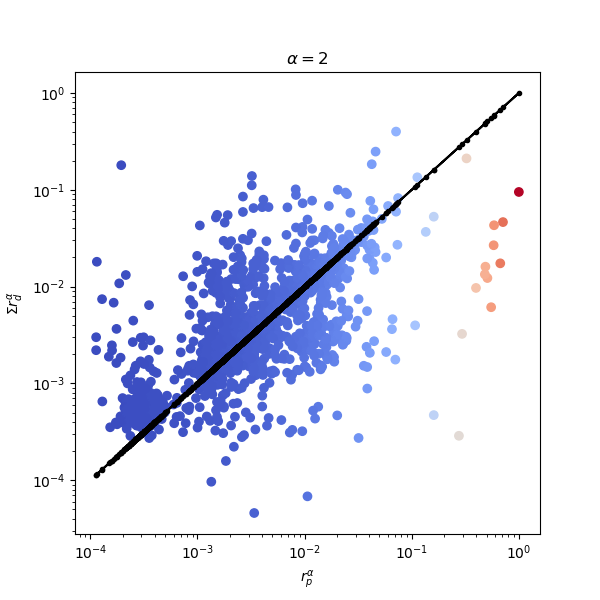

In [64]:
# scatter upstream and downstream radii ^2 etc
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
a = 2
sumds = getSumDS(upstream_filt,downstream_radii,a)
maxUS = np.max((np.array(upstream_filt)/1000)**a)
ax.scatter((np.array(upstream_filt)/1000)**a/maxUS, sumds/maxUS,c=np.array(upstream_filt)/1000,cmap='coolwarm')
ax.plot((np.array(upstream_filt)/1000)**a/maxUS, (np.array(upstream_filt)/1000)**a/maxUS, 'k.-')
ax.set_ylabel(r'$\Sigma r_d^{\alpha}$')
ax.set_xlabel(r'$r_p^{\alpha}$')
ax.set_title(r'$\alpha =$' + str(a))
ax.set_yscale('log')
ax.set_xscale('log')
#plt.coolwarm()
#ax.scatter(np.array(upstream_radii)/1000, sumds)

In [105]:
basal_skel_distToRoot = nrn.distance_to_root(basal_dendrite_skel)
basal_branch_distToRoot_test = basal_skel_distToRoot[basal_dendrite_skel.to_mesh_index == seg.mesh_ind_filt]

In [185]:
# workflow for getting individual branch radii/area - apical
import copy
from tqdm import tqdm
from meshparty import meshwork
from angularUtils import *

apical_branch_reff = []
apical_branch_areaFactor = []
apical_branch_distToRoot = []

basal_branch_reff = []
basal_branch_areaFactor = []
basal_branch_distToRoot = []

cell_ids = []


# get cell ids of particular cell type
info_5PET = dend_to_neuron_soma_df[dend_to_neuron_soma_df.cell_type == '5P-ET']
info_23P = dend_to_neuron_soma_df[dend_to_neuron_soma_df.cell_type == '23P']

Ncells = len(info_23P)
Ncells = 1
for i in range(Ncells):
    # filter branch points by those in apical vs basal
    neuron_id = info_5PET.iloc[i].pt_root_id
    #nuc_id = info_23P.iloc[i].target_id

    #if (len(neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values) == 0):
    #    continue
    nuc_id=neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values[0]
    #nuc_type = neuron_soma_df.query(f'pt_root_id=={neuron_id}').cell_type.values[0]
    
    mesh_filename = f"{neuron_id}_{nuc_id}.h5"
    folder_name = f"{neuron_id}_{nuc_id}"
    nrnname = os.path.join(data_root,folder_name,mesh_filename)
    nrn = read_h5(nrnname)
    if (not(nrn)):
        continue
    print(i)
    
    cell_ids.append(neuron_id)

    apical_dendrite_mesh = nrn.anno.apical_mesh_labels.mesh_index
    apical_dendrite_skel = nrn.anno.apical_mesh_labels.skel_index
    
    apical_branch_points = nrn.skeleton.SkeletonIndex(list(set(np.array(nrn.skeleton.branch_points)).intersection(np.array(apical_dendrite_skel))))
    
    seg = nrn.anno.segment_properties.filter_query(apical_dendrite_skel.to_mesh_mask).df
    #apical_branch_reff.append(seg.r_eff.unique())
    apical_branch_reff.append(seg.r_eff)
    apical_branch_areaFactor.append(seg.area_factor)
    apical_branch_distToRoot.append(nrn.distance_to_root(apical_dendrite_skel))
    '''
    branch_children=nrn.skeleton.child_nodes(dendrite_branch_points)
    branch_parents=nrn.skeleton.parent_nodes(dendrite_branch_points)
    for par in branch_parents.to_mesh_region:
        seg=nrn.anno.segment_properties.filter_query(par.to_mesh_mask).df
        #seg.drop_duplicates(subset = ["area"])
        upstream_info.append(seg)
        upstream_radii.append(seg.r_eff.unique())
        #upstream_radii.append(seg.area.unique())
        upstream_area_factor.append(seg.area_factor.unique())
    for child in branch_children:
        seg=nrn.anno.segment_properties.filter_query(child.to_mesh_mask).df
        #seg.drop_duplicates(subset = ["area"])
        downstream_info.append(seg)
        downstream_radii.append(seg.r_eff.unique())
        #downstream_radii.append(seg.area.unique())
        downstream_area_factor.append(seg.area_factor.unique())
        
        '''
    basal_dendrite_mesh = nrn.anno.basal_mesh_labels.mesh_index
    basal_dendrite_skel = nrn.anno.basal_mesh_labels.skel_index
    
    basal_branch_points = nrn.skeleton.SkeletonIndex(list(set(np.array(nrn.skeleton.branch_points)).intersection(np.array(basal_dendrite_skel))))
    
    seg = nrn.anno.segment_properties.filter_query(basal_dendrite_skel.to_mesh_mask).df
    #basal_branch_reff.append(seg.r_eff.unique())
    basal_branch_reff.append(seg.r_eff)
    basal_branch_areaFactor.append(seg.area_factor)
    basal_branch_distToRoot.append(nrn.distance_to_root(seg.mesh_ind_filt))
    #basal_branch_distToRoot.append(basal_skel_distToRoot[basal_dendrite_skel.to_mesh_index == seg.mesh_ind_filt])
    





0


In [125]:
# make a dataframe with every cell being a row, column values being apical and basal branch properties + pt root id of cell
cell_seg_df = pd.DataFrame({'cell_id': cell_ids})
cell_seg_df['basal_branch_reff'] = basal_branch_reff
cell_seg_df['basal_branch_areaFactor'] = basal_branch_areaFactor
cell_seg_df['basal_branch_distToRoot'] = basal_branch_distToRoot
cell_seg_df['apical_branch_reff'] = apical_branch_reff
cell_seg_df['apical_branch_areaFactor'] = apical_branch_areaFactor
cell_seg_df['apical_branch_distToRoot'] = apical_branch_distToRoot

In [126]:
len(basal_branch_distToRoot[0])

5665

In [127]:
len(basal_branch_areaFactor[0])

5665

In [102]:
seg

,area,area_factor,is_root,len,mesh_ind,r_eff,seg_num,strahler,vol,mesh_ind_filt
2530,746978112,2.361280,False,125701.312500,2530,400.535171,23,1,63353556480,2530
2531,746978112,2.361280,False,125701.312500,2531,400.535171,23,1,63353556480,2531
2574,746978112,2.361280,False,125701.312500,2574,400.535171,23,1,63353556480,2574
2575,746978112,2.361280,False,125701.312500,2575,400.535171,23,1,63353556480,2575
2576,746978112,2.361280,False,125701.312500,2576,400.535171,23,1,63353556480,2576
...,...,...,...,...,...,...,...,...,...,...
20536,831879040,2.409675,False,135889.390625,20536,404.330249,232,1,69792360960,20536
20558,737646336,2.323829,False,129688.781250,20558,389.548628,205,1,61826639360,20558
20576,737646336,2.323829,False,129688.781250,20576,389.548628,205,1,61826639360,20576
20593,737646336,2.323829,False,129688.781250,20593,389.548628,205,1,61826639360,20593


Text(0.5, 1.0, 'Example 5P-ET cell, Apical')

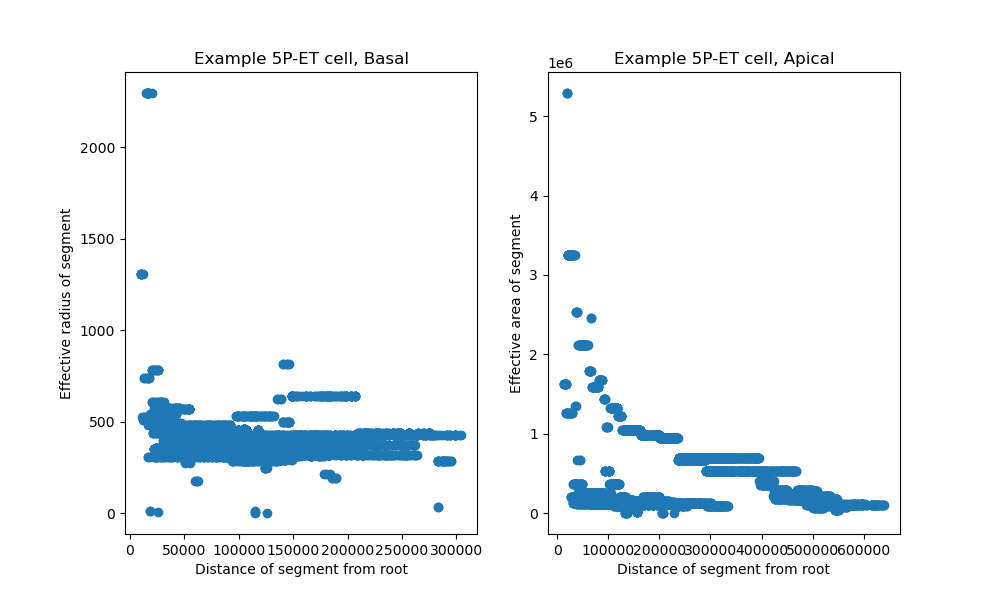

In [190]:
#fig = plt.subplots(figsize=(6,6))
f, (ax1, ax2) = plt.subplots(1, 2,figsize = (10,6))
ax1.scatter(basal_branch_distToRoot[0], basal_branch_reff[0])

#ax.plot((np.array(upstream_filt)/1000)**a/maxUS, (np.array(upstream_filt)/1000)**a/maxUS, 'k.-')
ax1.set_ylabel('Effective radius of segment')
ax1.set_xlabel('Distance of segment from root')
ax1.set_title('Example 5P-ET cell, Basal')
#ax.set_yscale('log')
#ax.set_xscale('log')

ax2.scatter(apical_branch_distToRoot[0], apical_branch_reff[0]**2)

#ax.plot((np.array(upstream_filt)/1000)**a/maxUS, (np.array(upstream_filt)/1000)**a/maxUS, 'k.-')
ax2.set_ylabel('Effective area of segment')
ax2.set_xlabel('Distance of segment from root')
ax2.set_title('Example 5P-ET cell, Apical')

(array([0.00080189, 0.00034367, 0.0018329 , 0.00297847, 0.00171835,
        0.00045823, 0.00022911, 0.00011456, 0.        , 0.        ,
        0.        , 0.00011456, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00011456]),
 array([4.82849571e-01, 1.15342390e+02, 2.30201931e+02, 3.45061472e+02,
        4.59921012e+02, 5.74780553e+02, 6.89640094e+02, 8.04499634e+02,
        9.19359175e+02, 1.03421872e+03, 1.14907826e+03, 1.26393780e+03,
        1.37879734e+03, 1.49365688e+03, 1.60851642e+03, 1.72337596e+03,
        1.83823550e+03, 1.95309504e+03, 2.06795458e+03, 2.18281412e+03,
        2.29767366e+03]),
 [<matplotlib.patches.Polygon at 0x7fd0917edd30>])

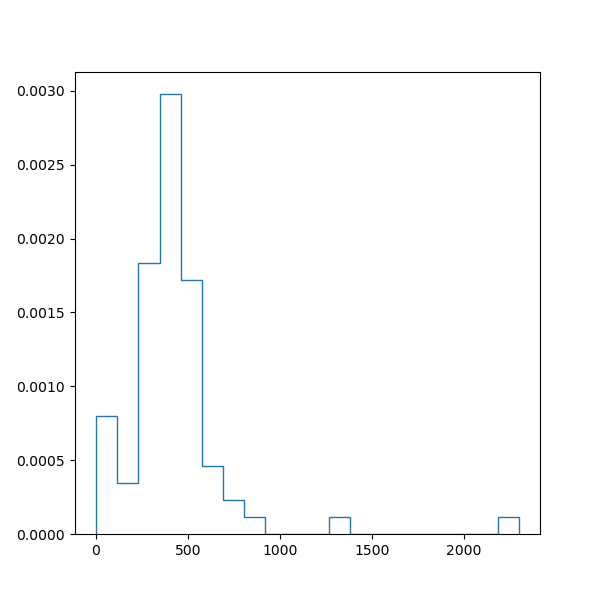

In [143]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
#ax.hist(np.unique(basal_branch_distToRoot[0]),bins=20)
#ax.hist(np.unique(apical_branch_distToRoot[0]),bins=20,density=True,histtype='step')
#ax.hist(np.unique(apical_branch_reff[0]),bins=20,density=True,histtype='step')
ax.hist(np.unique(basal_branch_reff[0]),bins=20,density=True,histtype='step')

Text(0.5, 1.0, '5P-ET')

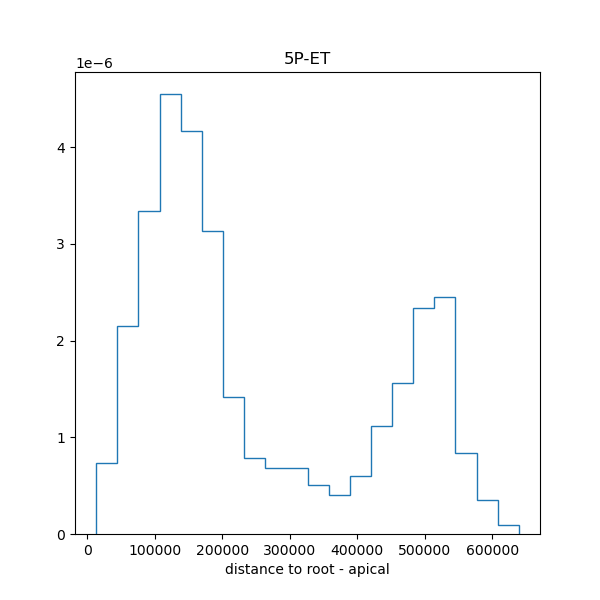

In [170]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.hist(np.unique(apical_branch_distToRoot[0]),bins=20,density=True,histtype='step')
#ax.hist(np.unique(basal_branch_distToRoot[0]),bins=20,density=True,histtype='step')
#ax.set_xlabel('distance to root - basal')
ax.set_xlabel('distance to root - apical')
ax.set_title('5P-ET')

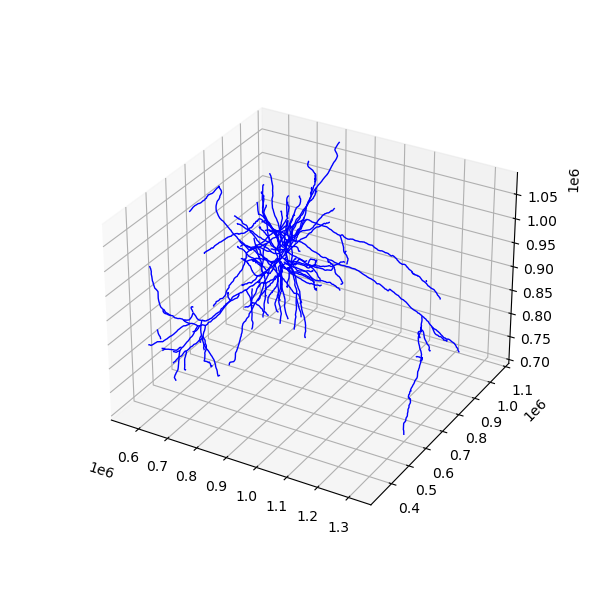

In [172]:
# So a better way to plot a neuron is to use cover_paths
# and plot those as 3d lines
def plot_neuron_skeleton(neuron, ax, c='b', linewidth=1):

    for cover_path in neuron.skeleton.cover_paths:
        path_verts = neuron.skeleton.vertices[cover_path,:]
        ax.plot(path_verts[:,0], path_verts[:,1], path_verts[:,2], c=c, linewidth=linewidth)

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')   
plot_neuron_skeleton(nrn, ax)

Text(0.5, 0.92, '5P-ET[0]')

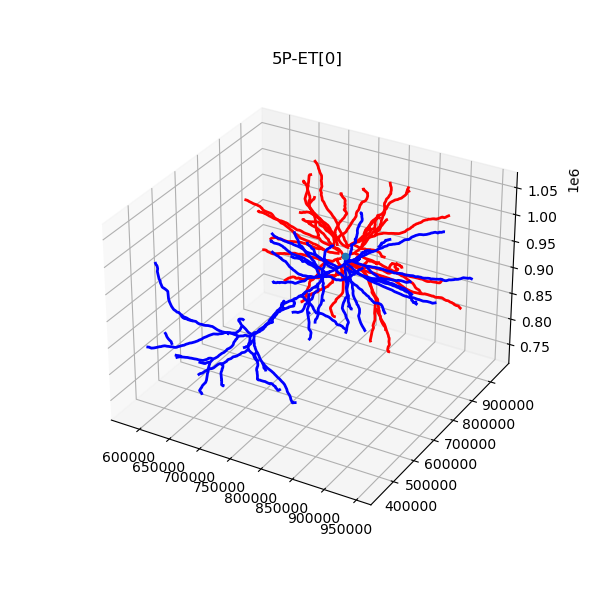

In [183]:
# plot the apical tuft of this neuron?
i = 0
neuron_id = info_5PET.iloc[i].pt_root_id
nuc_id=neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values[0]
mesh_filename = f"{neuron_id}_{nuc_id}.h5"
folder_name = f"{neuron_id}_{nuc_id}"
nrnname = os.path.join(data_root,folder_name,mesh_filename)
nrn = read_h5(nrnname)

apical_dendrite_skel = nrn.anno.apical_mesh_labels.skel_index
basal_dendrite_skel = nrn.anno.basal_mesh_labels.skel_index
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection="3d")

#plot_neuron_skeleton(nrn, ax, "b")
ax.scatter(
    nrn.skeleton.root_position[0],
    nrn.skeleton.root_position[1],
    nrn.skeleton.root_position[2],
)

# This part is equivalent to:
# nrn.apply_mask( nrn.skeleton.cover_paths[0].to_mesh_mask )
# plot_neuron_skeleton(nrn, ax, "r", linewidth=2)
# nrn.reset_mask()

with nrn.mask_context(basal_dendrite_skel.to_mesh_mask ):
    plot_neuron_skeleton(nrn, ax, "r", linewidth=2)
with nrn.mask_context(apical_dendrite_skel.to_mesh_mask ):
    plot_neuron_skeleton(nrn, ax, "b", linewidth=2)
ax.set_title('5P-ET[0]')

In [12]:
tun_orac=pd.read_feather('tuning_curve_oracle.feather')

In [13]:
coreg_df = client.materialize.query_table('functional_coreg')
coreg_merge=pd.merge(coreg_df, tun_orac,
         right_on=['scan_session', 'scan_idx', 'unit_id'], left_on=['session', 'scan_idx', 'unit_id'])

In [14]:
highDSIdf = coreg_merge[coreg_merge.dsi>0.3]
lowDSIdf = coreg_merge[coreg_merge.dsi<0.02]

In [15]:
len(lowDSIdf)

331

In [18]:
# alternate way using forrest's method
import cloudfiles
import io
from meshparty import meshwork
import matplotlib.pyplot as plt
import os
cloud_path = 'gs://allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups'
cf = cloudfiles.CloudFiles(cloud_path, use_https=True)
byt=cf.get('864691134884741370_195614/864691134884741370_195614.h5')
bio = io.BytesIO(byt)
mw=meshwork.load_meshwork(bio)

In [19]:
os.path.join(data_root,mesh_filename)

'gs://allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups/864691135467558284_583817.h5'

100%|█████████████████████████████████████████| 615/615 [08:16<00:00,  1.24it/s]


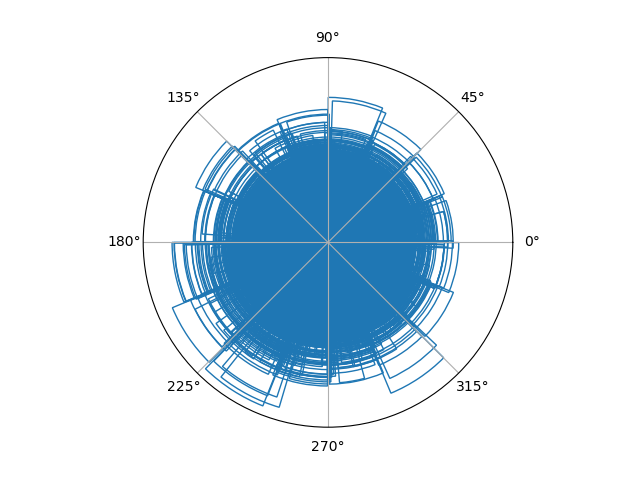

In [69]:
# iterate over valid neurons (shorter list) - get their DSIs, OSIs, pref dir, pref or
# get all of these from morphology - as well as angular heterogeneity metric
# save calculated stuff to dataframes
import copy
from tqdm import tqdm
from meshparty import meshwork
from angularUtils import *
from meshparty.skeleton import resample
from scipy import signal
coreg_df_DSIordered = pd.concat([highDSIdf, lowDSIdf])
coreg_df_DSIordered = coreg_df_DSIordered.sort_values(by=['dsi'],ascending=False)
#coreg_df_DSIordered = .sort_values(by=['dsi'],ascending=False)
Ncells = len(coreg_df_DSIordered)
pref_dir_morph = np.zeros((Ncells,1))
pref_dir_morph[:] = np.nan
pref_or_morph = np.zeros((Ncells,1))
pref_or_morph[:] = np.nan
DSI_act = np.zeros((Ncells,1))
DSI_act[:] = np.nan
OSI_act = np.zeros((Ncells,1))
OSI_act[:] = np.nan
nuc_id_list = np.zeros((Ncells,1))
nuc_id_list[:] = np.nan
mesh_files = []
pref_dir_act = np.zeros((Ncells,1))
pref_dir_act[:] = np.nan
pref_or_act = np.zeros((Ncells,1))
pref_or_act[:] = np.nan
angularHet_basal = np.zeros((Ncells,1))
angularHet_basal[:] = np.nan
angularHet_apical = np.zeros((Ncells,1))
angularHet_apical[:] = np.nan
nuc_type = [None] * Ncells
#nuc_type[:] = np.nan
fig,ax = plt.subplots(subplot_kw={'projection': 'polar'})
neuron_soma_df = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117')

for i in tqdm(range(Ncells)):
    neuron_id = coreg_df_DSIordered.iloc[i].pt_root_id
    #print(neuron_id)
    
   
    if (len(neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values) == 0):
        continue
        
    nuc_id = neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values[0]
    nuc_id_list[i] = nuc_id
    mesh_filename = f"{neuron_id}_{nuc_id}.h5"
    folder_name = f"{neuron_id}_{nuc_id}"
    
    #nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_filename))
    nrn = read_h5(os.path.join(data_root,folder_name,mesh_filename))
    # if no h5 file is detected, continue without implementing rest of the loop
    if (not(nrn)):
        continue
    
    pref_dir_act[i] = coreg_df_DSIordered.iloc[i].pref_dir * (np.pi/180)
    pref_or_act[i] = coreg_df_DSIordered.iloc[i].pref_ori * (np.pi/180)
    DSI_act[i] = coreg_df_DSIordered.iloc[i].dsi
    OSI_act[i] = coreg_df_DSIordered.iloc[i].osi
    
    #nuc_type.append(neuron_soma_df.query(f'pt_root_id=={neuron_id}').cell_type.values[0])
    nuc_type[i] = neuron_soma_df.query(f'pt_root_id=={neuron_id}').cell_type.values[0]
    #mesh_filename = f"{neuron_id}_{nuc_id}.h5"
    mesh_files.append(mesh_filename)

    
    
    # get basal dendrite mesh for pref dir
    basal_dendrite_mesh = nrn.anno.basal_mesh_labels.mesh_index
    basal_dendrite_skel = nrn.anno.basal_mesh_labels.skel_index
    basal_dendrite_mask = nrn.anno.basal_mesh_labels.skel_index.to_mesh_mask
    
    
    # get apical dendrite mesh
    apical_dendrite_mesh = nrn.anno.apical_mesh_labels.mesh_index
    apical_dendrite_skel = nrn.anno.apical_mesh_labels.skel_index
    apical_dendrite_mask = nrn.anno.apical_mesh_labels.skel_index.to_mesh_mask
    
    syndf_basal = nrn.anno.post_syn.filter_query(basal_dendrite_mask).df
    syndf_apical = nrn.anno.post_syn.filter_query(apical_dendrite_mask).df
    #syndf_axon = nrn.anno.pre_syn.df
    
    if (len(syndf_basal) == 0):
        continue
    
    syn_pos_basal = np.vstack(syndf_basal['ctr_pt_position'].values)
    syn_pos_basal_norm = np.column_stack((syn_pos_basal[:,0]*4, syn_pos_basal[:,1]*4, syn_pos_basal[:,2]*40))
    syn_size_basal = np.squeeze(np.vstack(syndf_basal['size'].values))
    #skeleton_vertices = syn_pos_basal_norm
    
    #
    #syn_pos_axon = np.vstack(syndf_axon['ctr_pt_position'].values)
    #syn_pos_axon_norm = np.column_stack((syn_pos_axon[:,0]*4, syn_pos_axon[:,1]*4, syn_pos_axon[:,2]*40))
    #skeleton_vertices = syn_pos_axon_norm
    
    # get pref morph dir from basal part
    #skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.basal_mesh_labels.skel_mask)]
    skeleton_vertices = syn_pos_basal_norm
    nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
    if (len(skeleton_vertices) == 0):
        continue
    #somapos = [nrn_somapos[0], nrn_somapos[1], nrn_somapos[2]]
    
    
    skel_pos_radial, majorAxis,_, _ = getRadialCoord(skeleton_vertices, nrn_somapos)
    #skel_pos_radial_farther = skel_pos_radial[skel_pos_radial[:,0] > 0.2*np.max(skel_pos_radial[:,0])]
    x = skel_pos_radial[:,1]
    #x = skel_pos_radial_farther[:,1]
    x = (x+np.pi) % (2*np.pi) - np.pi
    #bins = np.linspace(-np.pi, np.pi, num=17)
    n, bins, patches = circular_hist(ax, x, weights=syn_size_basal, bins=16, density=True, offset=0, gaps=True)
    #n, bins = np.histogram(x, bins=bins)
    pref_dir_morph[i] = (bins[n.argmax()] + bins[n.argmax() + 1])/2 
    #pref_dir_morph[i] = bins[n.argmax()]
    #theta[i] = np.arctan2(majorAxis[1],majorAxis[0]) + np.pi
    #print(pref_dir_morph[i])
    angularHet_basal[i] = np.max(n)/np.mean(n)
    
    # get pref morph or from apical part
    if (len(syndf_apical) == 0):
        continue
    
    syn_pos_apical = np.vstack(syndf_apical['ctr_pt_position'].values)
    syn_pos_apical_norm = np.column_stack((syn_pos_apical[:,0]*4, syn_pos_apical[:,1]*4, syn_pos_apical[:,2]*40))
    syn_size_apical = np.squeeze(np.vstack(syndf_apical['size'].values))
    #skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.apical_mesh_labels.skel_mask)]
    skeleton_vertices = syn_pos_apical_norm
    nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
    if (len(skeleton_vertices) == 0):
        continue
    #somapos = [nrn_somapos[0], nrn_somapos[1], nrn_somapos[2]]
    
    
    skel_pos_radial, majorAxis,_, _ = getRadialCoord(skeleton_vertices, nrn_somapos)
    #skel_pos_radial_farther = skel_pos_radial[skel_pos_radial[:,0] > 0.2*np.max(skel_pos_radial[:,0])]
    x = skel_pos_radial[:,1]
    #x = skel_pos_radial_farther[:,1]
    x = (x+np.pi) % (2*np.pi) - np.pi
    #bins = np.linspace(-np.pi, np.pi, num=17)
    n, bins, patches = circular_hist(ax, x, weights=syn_size_apical, bins=16, density=True, offset=0, gaps=True)
    #n, bins = np.histogram(x, bins=bins)
    pref_or_morph[i] = (bins[n.argmax()] + bins[n.argmax() + 1])/2 
    #pref_or_morph[i] = bins[n.argmax()]
    #theta[i] = np.arctan2(majorAxis[1],majorAxis[0]) + np.pi
    #print(pref_or_morph[i])
    angularHet_apical[i] = np.max(n)/np.mean(n)
    
    


    

In [70]:
# save these values to dataframe
coreg_df_DSIordered['angularHet_apical'] = angularHet_apical
coreg_df_DSIordered['angularHet_basal'] = angularHet_basal
coreg_df_DSIordered['pref_dir_morph'] = pref_dir_morph
coreg_df_DSIordered['pref_or_morph'] = pref_or_morph
coreg_df_DSIordered['cell_type'] = nuc_type

In [71]:
# save new dataframe to feather file
coreg_df_DSIordered.reset_index().to_feather('tun_orac_coreg_withMorph_synSize2.feather')

In [72]:
coreg_df_DSIordered_read = pd.read_feather('tun_orac_coreg_withMorph_synSize2.feather')

In [73]:
len(coreg_df_DSIordered)

615

Text(0.5, 0, 'Apical Angular Heterogeneity')

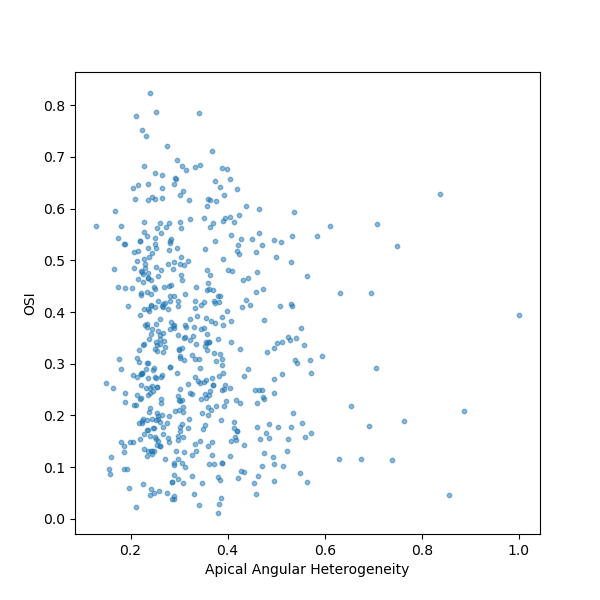

In [74]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(angularHet_apical/np.max(angularHet_apical[~np.isnan(angularHet_apical)]), OSI_act,s=10, alpha=0.5)
ax.set_ylabel('OSI')
ax.set_xlabel('Apical Angular Heterogeneity')

Text(0.5, 0, 'Basal Angular Heterogeneity')

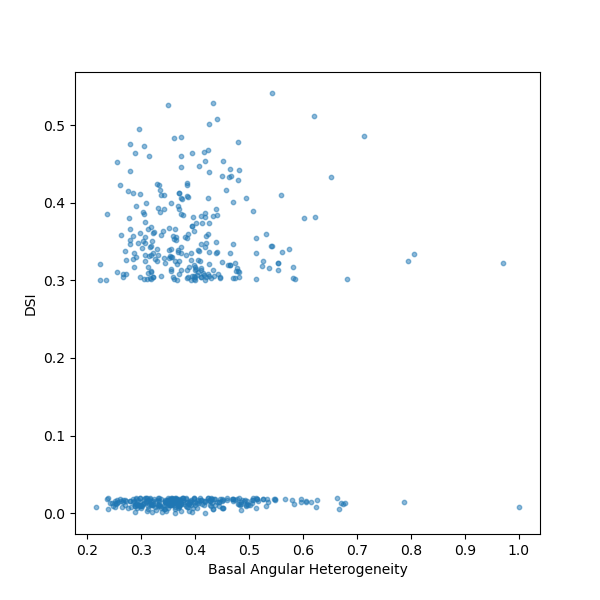

In [75]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(angularHet_basal/np.max(angularHet_basal[~np.isnan(angularHet_basal)]), DSI_act,s=10,alpha=0.5)
ax.set_ylabel('DSI')
ax.set_xlabel('Basal Angular Heterogeneity')

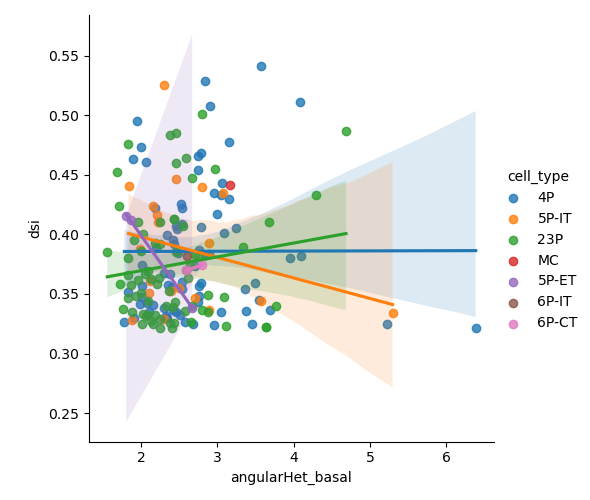

In [76]:
# seaborn scatter plot - color code by region?
import seaborn as sns
#fig, ax = plt.subplots(figsize=(6,6))
# we have nuc_id_list
#celltypes = neuron_soma_df[neuron_soma_df['target_id'].isin(nuc_id_list.squeeze())].cell_type.values
# append to dataframe
#coreg_df_DSIordered['cell_type'] = nuc_type
coreg_df_DSIordered_read = coreg_df_DSIordered_read.sort_values(by=['dsi'],ascending=False)
ax = sns.lmplot(data=coreg_df_DSIordered_read[:200], x="angularHet_basal", y="dsi",hue='cell_type')
#ax.set(ylim=(0, 1))

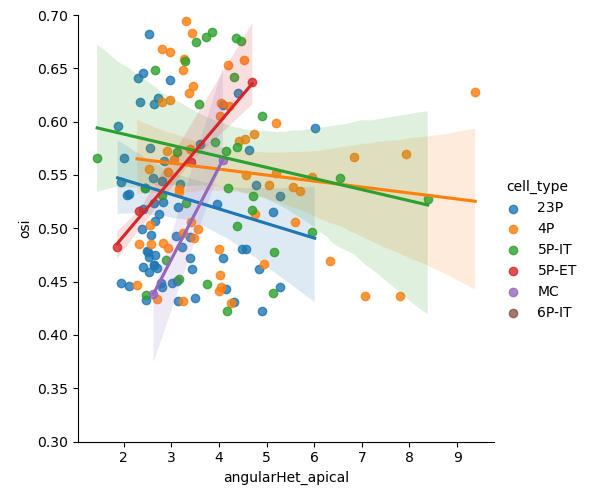

In [77]:
# seaborn scatter plot - color code by region?
import seaborn as sns
#fig, ax = plt.subplots(figsize=(6,6))
# we have nuc_id_list
#celltypes = neuron_soma_df[neuron_soma_df['target_id'].isin(nuc_id_list.squeeze())].cell_type.values
# append to dataframe
#coreg_df_DSIordered['cell_type'] = nuc_type
coreg_df_DSIordered_read = coreg_df_DSIordered_read.sort_values(by=['osi'],ascending=False)
ax = sns.lmplot(data=coreg_df_DSIordered_read[:200], x="angularHet_apical", y="osi",hue='cell_type')
#ax = sns.lmplot(data=coreg_df_DSIordered_read[coreg_df_DSIordered_read.cell_type == '5P-ET'], x="angularHet_apical", y="osi",hue='cell_type')
ax.set(ylim=(0.3, 0.7))

Text(0.5, 1.0, 'Synaptic density weighed by size,Ncells = 2x100')

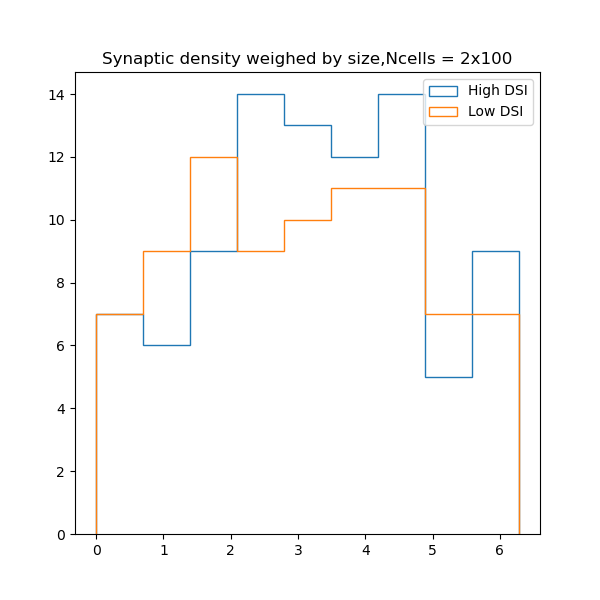

In [87]:
fig, ax = plt.subplots(figsize=(6,6))
coreg_df_DSIordered_read = coreg_df_DSIordered_read.sort_values(by=['dsi'],ascending=False)
DSIhist = (((coreg_df_DSIordered_read.pref_dir+np.pi) % (2*np.pi) - np.pi) - coreg_df_DSIordered_read.pref_dir_morph) % (2*np.pi)
#lowDSIhist = (((dsi_theta_lowDSI+np.pi) % (2*np.pi) - np.pi) - theta_lowDSI) % (2*np.pi)
#ax.hist(DSIhist,bins = np.linspace(0,2*np.pi,10), histtype='step')
nplot = 100
# already ordered for DSI, but still reorder
#coreg_df_DSIordered_read = coreg_df_DSIordered_read.sort_values(by=['dsi'],ascending=False)
highDSIhist = (((coreg_df_DSIordered_read.pref_dir[:nplot]+np.pi) % (2*np.pi) - np.pi) - coreg_df_DSIordered_read.pref_dir_morph[:nplot]) % (2*np.pi)
lowDSIhist = (((coreg_df_DSIordered_read.pref_dir[-nplot:]+np.pi) % (2*np.pi) - np.pi) - coreg_df_DSIordered_read.pref_dir_morph[-nplot:]) % (2*np.pi)
#ax.hist(pref_dir_morph,bins = np.linspace(-np.pi,np.pi,20), histtype='step')
ax.hist(highDSIhist, bins = np.linspace(0,2*np.pi,10), histtype='step')
ax.hist(lowDSIhist, bins = np.linspace(0,2*np.pi,10), histtype='step')
ax.legend(['High DSI', 'Low DSI'])
ax.set_title('Synaptic density weighed by size,Ncells = 2x'+str(nplot))

Text(0.5, 1.0, 'Synaptic density weighed by size, Ncells = 2x100')

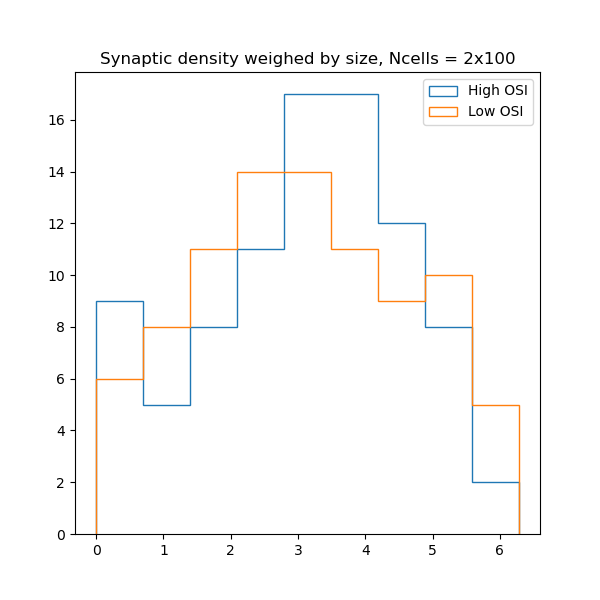

In [86]:
fig, ax = plt.subplots(figsize=(6,6))
# order by OSI
coreg_df_DSIordered_read = coreg_df_DSIordered_read.sort_values(by=['osi'],ascending=False)
OSIhist = (((coreg_df_DSIordered_read.pref_ori+np.pi) % (2*np.pi) - np.pi) - coreg_df_DSIordered_read.pref_or_morph) % (2*np.pi)
#lowDSIhist = (((dsi_theta_lowDSI+np.pi) % (2*np.pi) - np.pi) - theta_lowDSI) % (2*np.pi)
#ax.hist(DSIhist,bins = np.linspace(0,2*np.pi,10), histtype='step')
nplot = 100

highOSIhist = (((coreg_df_DSIordered_read.pref_ori[:nplot]+np.pi) % (2*np.pi) - np.pi) - coreg_df_DSIordered_read.pref_or_morph[:nplot]) % (2*np.pi)
lowOSIhist = (((coreg_df_DSIordered_read.pref_ori[-nplot:]+np.pi) % (2*np.pi) - np.pi) - coreg_df_DSIordered_read.pref_or_morph[-nplot:]) % (2*np.pi)
#ax.hist(pref_dir_morph,bins = np.linspace(-np.pi,np.pi,20), histtype='step')
ax.hist(highOSIhist, bins = np.linspace(0,2*np.pi,10), histtype='step')
ax.hist(lowOSIhist, bins = np.linspace(0,2*np.pi,10), histtype='step')
ax.legend(['High OSI', 'Low OSI'])
ax.set_title('Synaptic density weighed by size, Ncells = 2x'+str(nplot))

In [80]:
from astropy.stats import circcorrcoef
nplotlist = np.arange(10,250,10)
circoeff = np.zeros((len(nplotlist),1))
i = 0
for nplot in nplotlist:
    coreg_df_DSIordered_read = coreg_df_DSIordered_read.sort_values(by=['dsi'],ascending=False)
    pref_dir_dsi = (coreg_df_DSIordered_read.pref_dir[:nplot]+np.pi) % (2*np.pi) - np.pi
    pref_dir_morph = (coreg_df_DSIordered_read.pref_dir_morph[:nplot]+np.pi) % (2*np.pi) - np.pi
    circoeff[i] = circcorrcoef(np.squeeze(pref_dir_dsi), np.squeeze(pref_dir_morph))
    i = i+1
    
circoeff_lowDSI = np.zeros((len(nplotlist),1))
i = 0
for nplot in nplotlist:
    coreg_df_DSIordered_read = coreg_df_DSIordered_read.sort_values(by=['dsi'],ascending=False)
    pref_dir_dsi = (coreg_df_DSIordered_read.pref_dir[-nplot:]+np.pi) % (2*np.pi) - np.pi
    pref_dir_morph = (coreg_df_DSIordered_read.pref_dir_morph[-nplot:]+np.pi) % (2*np.pi) - np.pi
    circoeff_lowDSI[i] = circcorrcoef(np.squeeze(pref_dir_dsi), np.squeeze(pref_dir_morph))
    i = i+1

Text(0.5, 1.0, 'Circular correlation coeff for DSI as a fn of ncells')

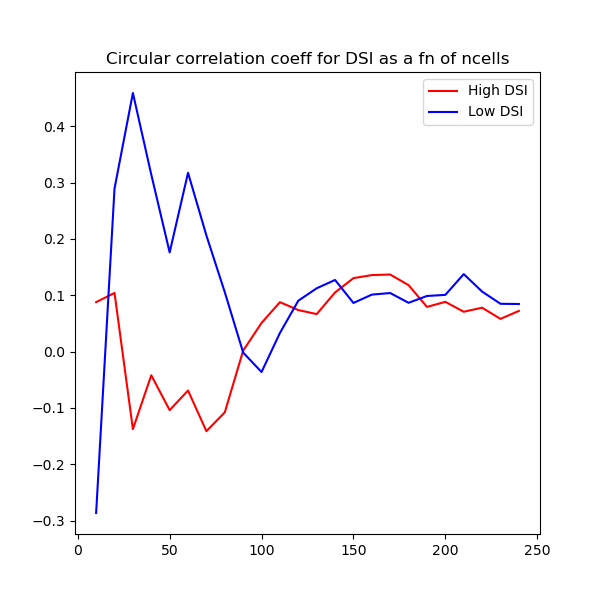

In [81]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(nplotlist, circoeff,'r')
ax.plot(nplotlist, circoeff_lowDSI,'b')
ax.legend(['High DSI', 'Low DSI'])
ax.set_title('Circular correlation coeff for DSI as a fn of ncells')

In [82]:
from astropy.stats import circcorrcoef
nplotlist = np.arange(10,250,10)
circoeff = np.zeros((len(nplotlist),1))
i = 0
for nplot in nplotlist:
    coreg_df_DSIordered_read = coreg_df_DSIordered_read.sort_values(by=['osi'],ascending=False)
    pref_or_dsi = (coreg_df_DSIordered_read.pref_ori[:nplot]+np.pi) % (2*np.pi) - np.pi
    pref_or_morph = (coreg_df_DSIordered_read.pref_or_morph[:nplot]+np.pi) % (2*np.pi) - np.pi
    circoeff[i] = circcorrcoef(np.squeeze(pref_or_dsi), np.squeeze(pref_or_morph))
    i = i+1
i = 0
circoeff_lowOSI = np.zeros((len(nplotlist),1))  
for nplot in nplotlist:
    coreg_df_DSIordered_read = coreg_df_DSIordered_read.sort_values(by=['osi'],ascending=False)
    pref_or_dsi = (coreg_df_DSIordered_read.pref_ori[-nplot:]+np.pi) % (2*np.pi) - np.pi
    pref_or_morph = (coreg_df_DSIordered_read.pref_or_morph[-nplot:]+np.pi) % (2*np.pi) - np.pi
    circoeff_lowOSI[i] = circcorrcoef(np.squeeze(pref_or_dsi), np.squeeze(pref_or_morph))
    i = i+1


Text(0.5, 1.0, 'Circular correlation coeff for OSI as a fn of ncells')

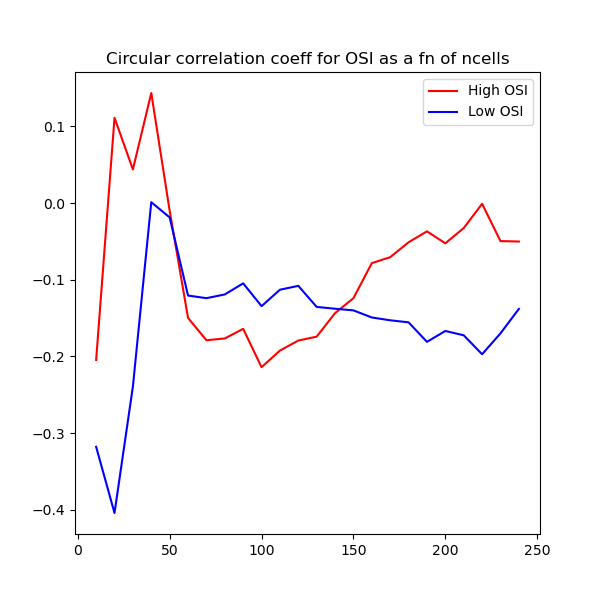

In [83]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(nplotlist, circoeff,'r')
ax.plot(nplotlist, circoeff_lowOSI,'b')
ax.legend(['High OSI', 'Low OSI'])
ax.set_title('Circular correlation coeff for OSI as a fn of ncells')

In [59]:
from astropy.stats import circcorrcoef
nplotlist = np.arange(10,250,10)
circoeff = np.zeros((len(nplotlist),1))
i = 0
for nplot in nplotlist:
    coreg_df_DSIordered_read = coreg_df_DSIordered_read.sort_values(by=['osi'],ascending=False)
    pref_or_dsi = (coreg_df_DSIordered_read.pref_ori[-nplot:]+np.pi) % (2*np.pi) - np.pi
    pref_or_morph = (coreg_df_DSIordered_read.pref_or_morph[-nplot:]+np.pi) % (2*np.pi) - np.pi
    circoeff[i] = circcorrcoef(np.squeeze(pref_or_dsi), np.squeeze(pref_or_morph))
    i = i+1

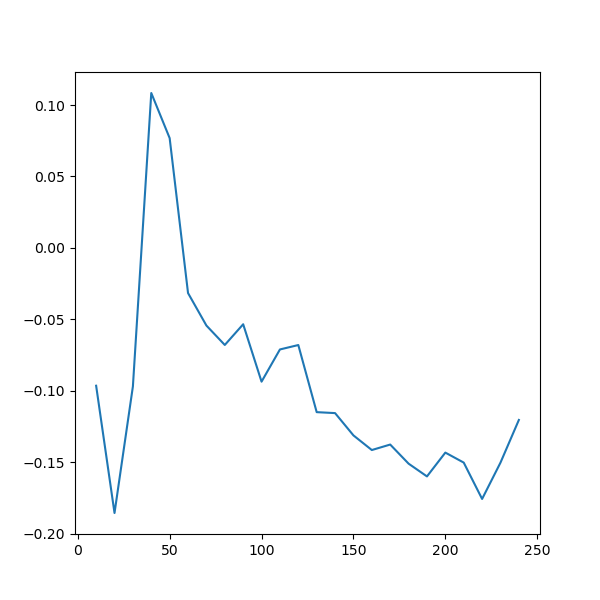

In [60]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(nplotlist, circoeff)

In [122]:
from astropy.stats import circcorrcoef
nplot = 20
pref_dir_dsi = (coreg_df_DSIordered_read.pref_dir[-nplot:]+np.pi) % (2*np.pi) - np.pi
pref_dir_morph = (coreg_df_DSIordered_read.pref_dir_morph[-nplot:]+np.pi) % (2*np.pi) - np.pi
circcorrcoef(np.squeeze(pref_dir_dsi), np.squeeze(pref_dir_morph))


-0.17482201545836382

In [111]:
from astropy.stats import circcorrcoef
nplot = 10
coreg_df_DSIordered_read = coreg_df_DSIordered_read.sort_values(by=['osi'],ascending=False)
pref_or_dsi = (coreg_df_DSIordered_read.pref_ori[:nplot]+np.pi) % (2*np.pi) - np.pi
pref_or_morph = (coreg_df_DSIordered_read.pref_or_morph[:nplot]+np.pi) % (2*np.pi) - np.pi
circcorrcoef(np.squeeze(pref_or_dsi), np.squeeze(pref_or_morph))

0.27605992782448174

In [112]:
from astropy.stats import circcorrcoef
nplot = 10
coreg_df_DSIordered_read = coreg_df_DSIordered_read.sort_values(by=['osi'],ascending=False)
pref_or_dsi = (coreg_df_DSIordered_read.pref_ori[-nplot:]+np.pi) % (2*np.pi) - np.pi
pref_or_morph = (coreg_df_DSIordered_read.pref_or_morph[-nplot:]+np.pi) % (2*np.pi) - np.pi
circcorrcoef(np.squeeze(pref_or_dsi), np.squeeze(pref_or_morph))

-0.28814478464824417

In [12]:
prf_df=client.materialize.query_table('proofreading_status_public_release')

In [13]:
ct_df = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117', desired_resolution=[1000,1000,1000])

In [14]:
nuc_df = client.materialize.query_table('nucleus_detection_v0', split_positions=True, desired_resolution=[1000,1000,1000])

In [15]:
nuc_df=pd.merge(nuc_df, ct_df[['target_id', 'cell_type']], left_on='id', right_on='target_id', how='left')

In [16]:
prfct_df=pd.merge(prf_df, ct_df, on='pt_root_id', how='left')

In [17]:
coregDF=pd.read_feather('coregDF_withMorph2.feather')
l23_ext_coreg=coregDF[coregDF.pt_root_id.isin(prfct_df.query('cell_type=="4P"').query('status_axon=="extended"').pt_root_id.values)]

In [18]:
dsi_osi_df = pd.read_feather('coreg_all_good_scans_dsi_osi.feather')
coreg_df = client.materialize.query_table('functional_coreg')
dsi_osi_df=pd.merge(coreg_df, dsi_osi_df[['pref_dir', '0.0', '22.5', '45.0', '67.5', '90.0', '112.5',
       '135.0', '157.5', '180.0', '202.5', '225.0', '247.5', '270.0', '292.5',
       '315.0', '337.5', 'null_dir', 'DSI', 'Act_Pref_Dir', 'OSI',
       'Act_Pref_Or', 'pref_or', 'null_or','id']], on='id')

In [19]:
root_id = l23_ext_coreg.iloc[0,:].pt_root_id

In [13]:
dsi_self = pd.merge(dsi_osi_df, dsi_osi_df, on='pt_root_id', how='inner')
dsi_self=dsi_self[dsi_self.id_x!=dsi_self.id_y]

<AxesSubplot:xlabel='pref_dir_x', ylabel='pref_dir_y'>

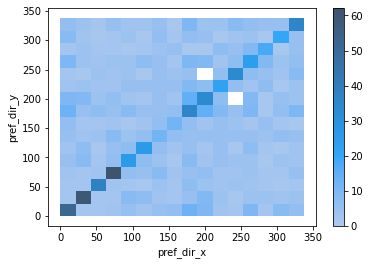

In [14]:
f, ax = plt.subplots()
sns.histplot(data=dsi_self, x='pref_dir_x', y='pref_dir_y',bins=16, ax=ax, cbar=True)


In [18]:
dangle = dsi_self.pref_dir_x - dsi_self.pref_dir_y
dsi_self['dpref_dir']=np.arctan2(np.sin(dangle), np.cos(dangle))

In [19]:
dsi_self['avg_DSI']=dsi_self.DSI_x/2 + dsi_self.DSI_y/2
dsi_self['avg_act']=dsi_self.Act_Pref_Dir_x/2 + dsi_self.Act_Pref_Dir_y/2

In [24]:
dsi_self.columns

Index(['id_x', 'valid_x', 'pt_supervoxel_id_x', 'pt_root_id', 'session_x',
       'scan_idx_x', 'unit_id_x', 'pt_position_x', 'pref_dir_x', '0.0_x',
       '22.5_x', '45.0_x', '67.5_x', '90.0_x', '112.5_x', '135.0_x', '157.5_x',
       '180.0_x', '202.5_x', '225.0_x', '247.5_x', '270.0_x', '292.5_x',
       '315.0_x', '337.5_x', 'null_dir_x', 'DSI_x', 'Act_Pref_Dir_x', 'OSI_x',
       'Act_Pref_Or_x', 'pref_or_x', 'null_or_x', 'id_y', 'valid_y',
       'pt_supervoxel_id_y', 'session_y', 'scan_idx_y', 'unit_id_y',
       'pt_position_y', 'pref_dir_y', '0.0_y', '22.5_y', '45.0_y', '67.5_y',
       '90.0_y', '112.5_y', '135.0_y', '157.5_y', '180.0_y', '202.5_y',
       '225.0_y', '247.5_y', '270.0_y', '292.5_y', '315.0_y', '337.5_y',
       'null_dir_y', 'DSI_y', 'Act_Pref_Dir_y', 'OSI_y', 'Act_Pref_Or_y',
       'pref_or_y', 'null_or_y', 'dpref_dir', 'avg_DSI', 'avg_act'],
      dtype='object')

<AxesSubplot:xlabel='dpref_dir', ylabel='avg_DSI'>

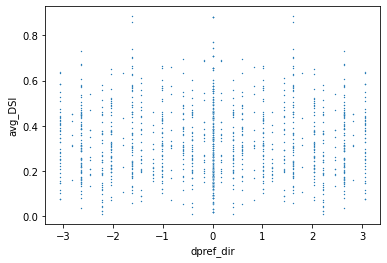

In [23]:
f, ax = plt.subplots()
sns.scatterplot(data=dsi_self,x='dpref_dir', y='avg_DSI',s=2,ax=ax)

<AxesSubplot:xlabel='dpref_dir', ylabel='avg_act'>

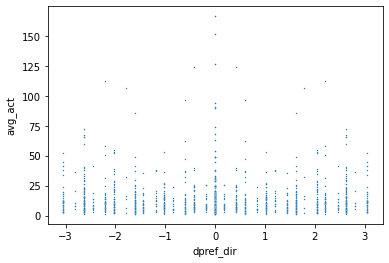

In [25]:
f, ax = plt.subplots()
sns.scatterplot(x='dpref_dir', y='avg_act',
                data=dsi_self, s=2,ax=ax)

<AxesSubplot:xlabel='dpref_dir', ylabel='avg_act'>

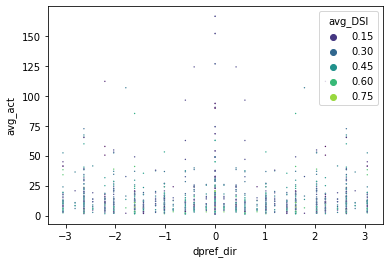

In [26]:
f, ax = plt.subplots()
sns.scatterplot(x='dpref_dir', y='avg_act', 
                hue='avg_DSI',palette=plt.cm.viridis, 
                data=dsi_self, s=2,ax=ax)

<AxesSubplot:xlabel='pref_dir_x', ylabel='pref_dir_y'>

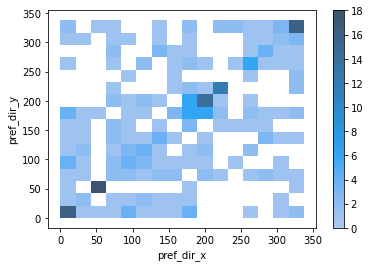

In [27]:
f, ax = plt.subplots()
sns.histplot(data=dsi_self.query('avg_act>20'), x='pref_dir_x', y='pref_dir_y',bins=16, ax=ax, cbar=True)


<AxesSubplot:xlabel='dpref_dir', ylabel='OSI_x'>

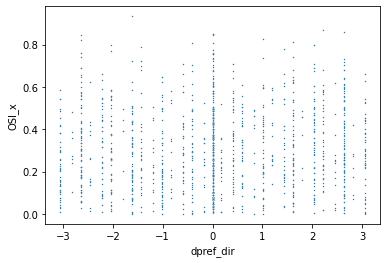

In [28]:
f, ax = plt.subplots()
sns.scatterplot(x='dpref_dir', y='OSI_x', data=dsi_self, s=2,ax=ax)

In [29]:
dsi_self.pref_dir_x.value_counts().shape

(16,)

In [30]:
dsi_osi_df.shape, dsi_self.shape

((8944, 32), (1586, 66))

In [31]:
dsi_self.drop_duplicates(subset=['id_x', 'id_y'], keep=False).shape

(1586, 66)

In [32]:
dsi_self.shape

(1586, 66)

In [33]:
dsi_self.shape

(1586, 66)

In [34]:
dsi_osi_df.query(f'pt_root_id=={root_id}')[['scan_idx', 'session','unit_id','pt_root_id', 'DSI','OSI', 'pref_dir', 'pref_or']]

,scan_idx,session,unit_id,pt_root_id,DSI,OSI,pref_dir,pref_or
96,7,4,5564,864691135718541617,0.566859,0.174294,0.0,135.0
1775,5,8,8350,864691135718541617,0.640613,0.491521,157.5,157.5


In [35]:
root_id

864691135718541617

In [36]:
syn_df = client.materialize.synapse_query(pre_ids=root_id,
                                          split_positions=True,
                                          desired_resolution=[1000,1000,1000])

In [152]:
syn_dfm=pd.merge(syn_df, nuc_df, left_on='post_pt_root_id', right_on='pt_root_id', how='inner')

In [153]:
delt_v=syn_dfm[['ctr_pt_position_x', 'ctr_pt_position_y', 'ctr_pt_position_z']].values-syn_dfm[['pt_position_x', 'pt_position_y', 'pt_position_z']].values

In [154]:
syn_dfm[['soma_to_syn_x', 'soma_to_syn_y', 'soma_to_syn_z']]=delt_v

In [155]:
syn_dfm['soma_to_syn_r']=np.linalg.norm(syn_dfm[['soma_to_syn_x', 'soma_to_syn_y', 'soma_to_syn_z']], axis=1)

In [156]:
syn_dfm['theta']=np.arctan2(syn_dfm.soma_to_syn_x, syn_dfm.soma_to_syn_z)

In [157]:
syn_dfm=syn_dfm.drop_duplicates(subset='id_x')

In [180]:
syn_dfm.merge(dsi_osi_df, left_on='post_pt_root_id', right_on='pt_root_id')

,id_x,valid_x,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_position_x,post_pt_position_y,post_pt_position_z,...,292.5,315.0,337.5,null_dir,DSI,Act_Pref_Dir,OSI,Act_Pref_Or,pref_or,null_or
0,133954227,t,642.320,683.584,910.68,86849806009668531,864691135753932237,642.400,683.952,910.80,...,10.911670,8.378872,7.886239,22.5,0.623543,17.120943,0.292127,12.775335,45.0,135.0
1,96423091,t,559.232,633.400,758.36,83962969041459235,864691135753932237,559.272,633.480,758.24,...,10.382027,15.945401,14.627197,90.0,0.273815,36.483517,0.439726,28.641140,90.0,0.0
2,108300450,t,600.680,760.912,696.88,85445041794907457,864691135753932237,600.504,761.152,696.68,...,4.090281,3.615450,5.830765,315.0,0.300496,6.721735,0.487695,5.615542,90.0,0.0
3,126226046,t,634.608,687.112,774.08,86568468002376450,864691135753932237,634.520,686.696,774.28,...,4.090281,3.615450,5.830765,315.0,0.300496,6.721735,0.487695,5.615542,90.0,0.0
4,185393273,t,777.328,667.664,1001.04,91493593638252359,864691135753932237,776.968,668.088,1001.04,...,4.277564,7.762255,6.088434,225.0,0.356171,25.277296,0.496858,18.638725,45.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,182525672,t,755.176,691.992,692.56,90720361079354402,864691135753932237,755.056,692.504,692.72,...,6.535955,19.199238,17.229132,337.5,0.163868,23.982376,0.217886,20.605755,157.5,67.5
136,171726958,t,736.128,696.552,701.08,90087179887496251,864691135753932237,735.792,696.632,701.04,...,3.685940,6.876083,3.689906,135.0,0.136044,6.876083,0.304835,6.224863,22.5,112.5
137,255144807,t,937.856,688.528,748.88,96983042073419955,864691135753932237,937.352,688.712,748.88,...,19.621037,20.112415,28.113522,45.0,0.208059,37.840328,0.230838,31.323238,45.0,135.0
138,125652888,t,623.216,744.896,714.44,86218548225528708,864691135753932237,623.048,745.072,714.56,...,0.933556,1.406676,2.144675,180.0,0.324549,3.715112,0.494895,2.954076,22.5,112.5


(-150.0, 150.0)

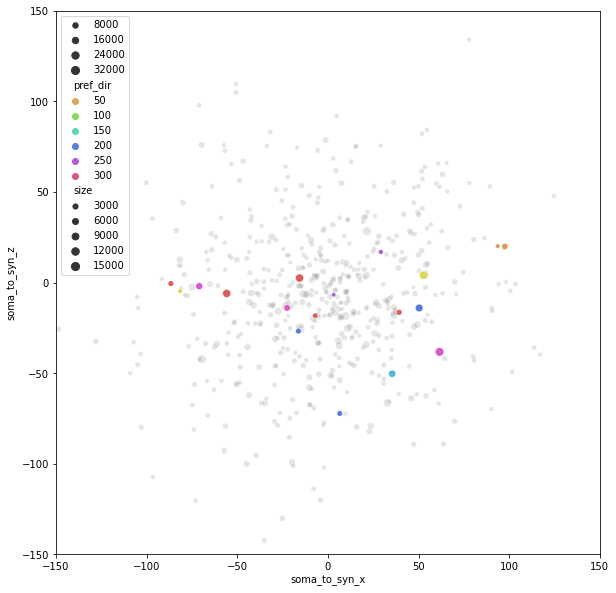

In [215]:
f, ax=plt.subplots(figsize=(10,10))
sns.scatterplot(x='soma_to_syn_x', y='soma_to_syn_z',c=[[.5,.5,.5]],
                data=syn_dfm, size='size',alpha=.2,ax=ax)
sns.scatterplot(x='soma_to_syn_x', y='soma_to_syn_z', hue='pref_dir',size='size', palette='hls',vmax=360,vmin=0,
                data=syn_dfm.merge(dsi_osi_df, left_on='post_pt_root_id', right_on='pt_root_id').query('DSI>.5').query('Act_Pref_Dir>10'), ax=ax)
ax.set_aspect('equal')
ax.set_xlim(-150,150)
ax.set_ylim(-150,150)


In [37]:
tun_orac=pd.read_feather('tuning_curve_oracle.feather')

In [38]:
tun_orac

,animal_id,scan_session,scan_idx,unit_id,direction,response_mean,osi,dsi,pref_dir,pref_ori,oracle
0,17797,4,7,1,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[0.866137, 0.917347, 0.949379, 0.865518, 0.704...",0.130614,0.081838,0.500663,0.500663,0.078895
1,17797,4,7,3,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[1.36077, 1.39851, 1.99043, 3.18652, 4.58155, ...",0.284172,0.060989,1.781440,1.781440,0.200469
2,17797,4,7,4,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[1.21418, 1.21815, 0.860304, 0.420344, 0.20278...",0.432913,0.101887,3.406990,0.265397,0.042252
3,17797,4,7,5,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[0.537714, 0.46008, 0.39988, 0.329272, 0.30109...",0.077473,0.151048,5.054350,1.912757,0.473355
4,17797,4,7,6,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[1.34916, 1.36445, 1.29873, 0.803745, 0.690824...",0.171036,0.067236,6.174000,3.032407,0.169292
...,...,...,...,...,...,...,...,...,...,...,...
115367,17797,9,6,5494,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[0.880217, 1.01791, 0.938047, 0.920616, 0.6407...",0.206578,0.107160,3.995770,0.854177,0.179751
115368,17797,9,6,5495,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[1.04271, 1.19028, 1.43485, 1.86599, 1.85754, ...",0.124026,0.110393,1.331250,1.331250,0.054913
115369,17797,9,6,5496,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[0.338954, 0.337982, 0.527279, 0.922358, 1.852...",0.408453,0.123545,1.804710,1.804710,0.042267
115370,17797,9,6,5497,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[1.52055, 1.37349, 0.982758, 0.937725, 0.91138...",0.147547,0.051513,0.039345,0.039345,0.115852


In [49]:
tun_orac.columns

Index(['animal_id', 'scan_session', 'scan_idx', 'unit_id', 'direction',
       'response_mean', 'osi', 'dsi', 'pref_dir', 'pref_ori', 'oracle'],
      dtype='object')

In [50]:
len(tun_orac[tun_orac.dsi>0.3])

3553

In [39]:
coreg_merge=pd.merge(coreg_df, tun_orac,
         right_on=['scan_session', 'scan_idx', 'unit_id'], left_on=['session', 'scan_idx', 'unit_id'])

In [53]:
coreg_merge.columns

Index(['id', 'valid', 'pt_supervoxel_id', 'pt_root_id', 'session', 'scan_idx',
       'unit_id', 'pt_position', 'animal_id', 'scan_session', 'direction',
       'response_mean', 'osi', 'dsi', 'pref_dir', 'pref_ori', 'oracle'],
      dtype='object')

In [57]:
len(coreg_merge[coreg_merge.dsi>0.3])

284

In [51]:
len(coreg_merge)

8944

In [40]:
dsi_self2 = pd.merge(coreg_merge, coreg_merge, on='pt_root_id', how='inner')
dsi_self2=dsi_self2[dsi_self2.id_x!=dsi_self2.id_y]

<AxesSubplot:xlabel='pref_dir_x', ylabel='pref_dir_y'>

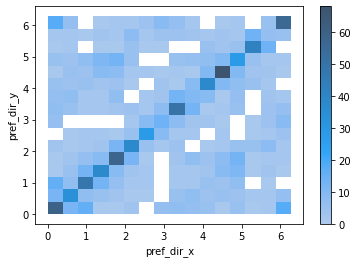

In [41]:
f, ax = plt.subplots()
sns.histplot(data=dsi_self2, x='pref_dir_x', y='pref_dir_y',bins=16, ax=ax, cbar=True)


In [42]:
dsi_self2.shape

(1586, 33)

In [43]:
dsi_self2[['session_x', 'scan_idx_x', 'unit_id_x']].value_counts()

session_x  scan_idx_x  unit_id_x
6          2           6616         24
           6           6252         18
5          7           7117         12
6          6           7170         12
8          5           2054         12
                                    ..
6          6           4594          1
5          7           2060          1
6          6           4671          1
                       4714          1
           7           3242          1
Length: 1026, dtype: int64

In [47]:
len(dsi_self2[(dsi_self2.dsi_y +dsi_self2.dsi_x)/2  > 0.3])

40

In [48]:
dsi_self2.columns

Index(['id_x', 'valid_x', 'pt_supervoxel_id_x', 'pt_root_id', 'session_x',
       'scan_idx_x', 'unit_id_x', 'pt_position_x', 'animal_id_x',
       'scan_session_x', 'direction_x', 'response_mean_x', 'osi_x', 'dsi_x',
       'pref_dir_x', 'pref_ori_x', 'oracle_x', 'id_y', 'valid_y',
       'pt_supervoxel_id_y', 'session_y', 'scan_idx_y', 'unit_id_y',
       'pt_position_y', 'animal_id_y', 'scan_session_y', 'direction_y',
       'response_mean_y', 'osi_y', 'dsi_y', 'pref_dir_y', 'pref_ori_y',
       'oracle_y'],
      dtype='object')

In [52]:
dsi_self2[(dsi_self2.dsi_y +dsi_self2.dsi_x)/2  > 0.3].pt_root_id

154      864691135446633812
155      864691135446633812
406      864691135415493050
407      864691135415493050
779      864691135229012362
780      864691135229012362
781      864691135229012362
782      864691135229012362
784      864691135229012362
785      864691135229012362
786      864691135229012362
787      864691135229012362
789      864691135229012362
790      864691135229012362
791      864691135229012362
792      864691135229012362
1678     864691135445539474
1679     864691135445539474
2160     864691135517422218
2161     864691135517422218
2162     864691135517422218
2164     864691135517422218
2165     864691135517422218
2166     864691135517422218
4264     864691135807308573
4266     864691135807308573
5738     864691135360229703
5739     864691135360229703
7806     864691135997647306
7807     864691135997647306
9377     864691135771971659
9378     864691135771971659
9501     864691136134413451
9502     864691136134413451
10475    864691135462735773
10476    86469113546

In [ ]:
# put condtions there: 
dsi_self2.query()